In [484]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset, WeightedRandomSampler,ConcatDataset

import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms
import torchvision.datasets



import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from skorch import NeuralNetClassifier
from skorch.helper import SliceDataset

import os
import seaborn as sns
import itertools
import PIL
from PIL import Image
import warnings
import splitfolders

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn.functional as fun

import pandas as pd
from tqdm.notebook import tqdm

#### Preprocessing data

In [9]:
#split data
splitfolders.ratio("../Comp_472 Group Project - Copy/all", output="../Comp_472 Group Project - Copy/dataset/all", seed=0, ratio=(.8, 0.1,0.1))
#splitfolders.ratio("../Comp_472 Group Project - Copy/female", output="../Comp_472 Group Project - Copy/dataset/female", seed=0, ratio=(.8, 0.1,0.1))
#splitfolders.ratio("../Comp_472 Group Project - Copy/male", output="../Comp_472 Group Project - Copy/dataset/male", seed=0, ratio=(.8, 0.1,0.1))

Copying files: 3804 files [00:04, 822.11 files/s] 
Copying files: 1928 files [00:09, 199.95 files/s]
Copying files: 1876 files [00:09, 204.67 files/s]


In [322]:
splitfolders.ratio("../Comp_472 Group Project - Copy/old dataset", output="../Comp_472 Group Project - Copy/old dataset", seed=0, ratio=(.8, 0.1,0.1))

Copying files: 1700 files [00:07, 218.19 files/s]


In [485]:
#resize the image into 32*32 pixels
train_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomCrop(32),
                                                 ])
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [486]:
#train data
data_dir = "../Comp_472 Group Project - Copy/dataset/all/train"
train_dataset = torchvision.datasets.ImageFolder(data_dir, transform = train_transform)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=700, shuffle = True
)


In [487]:
#test data
test_dir = "../Comp_472 Group Project - Copy/dataset/all/test"
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = train_transform)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=100, shuffle = True
)

In [488]:
# old data
data_dir2 = "../Comp_472 Group Project - Copy/old dataset/train"
train_dataset2 = torchvision.datasets.ImageFolder(data_dir2, transform = train_transform)

trainloader2 = torch.utils.data.DataLoader(
    train_dataset2, batch_size=700, shuffle = True
)

#### Modeling

In [489]:
#Model refence from Internet with modification of numbers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.8)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.6)
        x = self.fc3(x)
        return x

In [490]:
n = len(set(train_dataset.targets))
model = CNN()
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bi

In [491]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#### Training

In [492]:
#modify from https://www.programcreek.com/python/?CodeExample=train+epoch
def train(model, criterion, optimizer, trainloader, epochs):
  train_losses = np.zeros(epochs)

  for i in range(epochs):
    train_loss = []
    for inputs, targets in trainloader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)
    train_losses[i] = train_loss
    
    print(f'Epoch:{i+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
  return train_losses


In [493]:
#training takes about 5 minute for 20 epochs
train_losses = train(model, criterion, optimizer, trainloader, epochs=20)

Epoch:1/20, Train Loss: 1.6808
Epoch:2/20, Train Loss: 1.1027
Epoch:3/20, Train Loss: 0.8922
Epoch:4/20, Train Loss: 0.7917
Epoch:5/20, Train Loss: 0.7054
Epoch:6/20, Train Loss: 0.6472
Epoch:7/20, Train Loss: 0.5952
Epoch:8/20, Train Loss: 0.5451
Epoch:9/20, Train Loss: 0.4945
Epoch:10/20, Train Loss: 0.4369
Epoch:11/20, Train Loss: 0.3994
Epoch:12/20, Train Loss: 0.3502
Epoch:13/20, Train Loss: 0.3058
Epoch:14/20, Train Loss: 0.2640
Epoch:15/20, Train Loss: 0.2420
Epoch:16/20, Train Loss: 0.2071
Epoch:17/20, Train Loss: 0.1834
Epoch:18/20, Train Loss: 0.1569
Epoch:19/20, Train Loss: 0.1340
Epoch:20/20, Train Loss: 0.1192


In [494]:
print(train_losses)

[1.68084631 1.10272503 0.89221379 0.79171205 0.70537484 0.64721868
 0.59521296 0.54507481 0.49445585 0.43686243 0.39939549 0.3501756
 0.30577123 0.26395515 0.24200912 0.20712392 0.18338258 0.15685204
 0.13401294 0.11918312]


In [495]:
PATH = "MyModel.pt"

In [496]:
# save model
torch.save(model, PATH)

In [497]:
# load model
model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bi

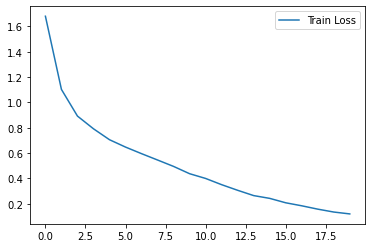

In [500]:
# train_losses =[1.68084631 1.10272503 0.89221379 0.79171205 0.70537484 0.64721868
#  0.59521296 0.54507481 0.49445585 0.43686243 0.39939549 0.3501756
#  0.30577123 0.26395515 0.24200912 0.20712392 0.18338258 0.15685204
#  0.13401294 0.11918312]
plt.plot(train_losses, label = "Train Loss")
plt.legend()
plt.show()

#### Evaluation

In [503]:
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true.append(targets[l])
            y_pred.append(targets[p])

In [504]:
#Use method from sklearn
#Question: why the accuracy thing keeps changing every time I run it
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.810
Precision:  0.833
Recall:  0.810
F1-measure:  0.812


In [505]:
#Method found on https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [506]:
confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_plot_labels = targets
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=cm_plot_labels)

[[71 16  4  4]
 [ 5 89  2  0]
 [ 6 10 85  2]
 [ 4 19  1 66]]


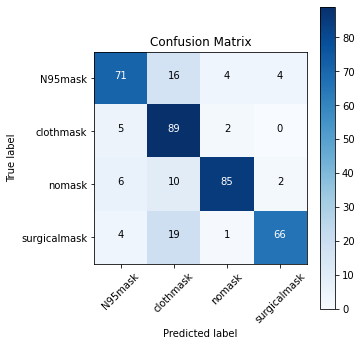

In [507]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

#### Bias evaluation for female

In [508]:
#female
data_dir0 = "../Comp_472 Group Project - Copy/dataset/female"
train_dataset0 = torchvision.datasets.ImageFolder(data_dir0, transform = train_transform)

trainloader0 = torch.utils.data.DataLoader(
    train_dataset0, batch_size=400, shuffle = True
)

# #female test
# test_dir0 = "../Comp_472 Group Project - Copy/dataset/female/test"
# test_dataset0 = torchvision.datasets.ImageFolder(test_dir0, transform = train_transform)

# testloader0 = torch.utils.data.DataLoader(
#     test_dataset0, batch_size=100, shuffle = True
# )


In [509]:
model.eval()

y_true0 = []
y_pred0 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader0:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true0.append(targets[l])
            y_pred0.append(targets[p])

In [510]:
accuracy = accuracy_score(y_true0, y_pred0)
precision = precision_score(y_true0, y_pred0, average="weighted")
recall = recall_score(y_true0, y_pred0, average="weighted")
f1 = f1_score(y_true0, y_pred0, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.924
Precision:  0.933
Recall:  0.924
F1-measure:  0.924


In [511]:
confusion_matrix(y_true=y_true0, y_pred=y_pred0)
cm_plot_labels = targets
cm0 = confusion_matrix(y_true=y_true0, y_pred=y_pred0, labels=cm_plot_labels)

[[429  38  10   5]
 [  2 468   3   2]
 [  1   7 486   0]
 [ 12  65   2 398]]


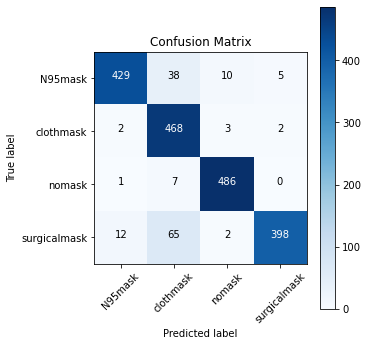

In [512]:
plot_confusion_matrix(cm=cm0, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

#### Bias evaluation for male

In [513]:
#male
data_dir1 = "../Comp_472 Group Project - Copy/dataset/male"
train_dataset1 = torchvision.datasets.ImageFolder(data_dir0, transform = train_transform)

trainloader1 = torch.utils.data.DataLoader(
    train_dataset1, batch_size=350, shuffle = True
)

# #male test
# test_dir1 = "../Comp_472 Group Project - Copy/dataset/male/test"
# test_dataset1 = torchvision.datasets.ImageFolder(test_dir0, transform = train_transform)

# testloader1 = torch.utils.data.DataLoader(
#     test_dataset1, batch_size=100, shuffle = True
# )

In [514]:
model.eval()

y_true1 = []
y_pred1 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in trainloader1:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true1.append(targets[l])
            y_pred1.append(targets[p])

In [515]:
accuracy = accuracy_score(y_true1, y_pred1)
precision = precision_score(y_true1, y_pred1, average="weighted")
recall = recall_score(y_true1, y_pred1, average="weighted")
f1 = f1_score(y_true1, y_pred1, average="weighted")


print(f"Accuracy: {accuracy: .3f}")
print(f"Precision: {precision: .3f}")
print(f"Recall: {recall: .3f}")
print(f"F1-measure: {f1: .3f}")

Accuracy:  0.925
Precision:  0.933
Recall:  0.925
F1-measure:  0.925


In [516]:
confusion_matrix(y_true=y_true1, y_pred=y_pred1)
cm_plot_labels = targets
cm1 = confusion_matrix(y_true=y_true1, y_pred=y_pred1, labels=cm_plot_labels)

[[427  38   3  14]
 [  3 472   0   0]
 [  2   6 486   0]
 [ 13  62   4 398]]


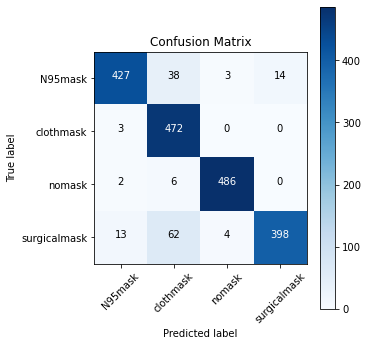

In [517]:
plot_confusion_matrix(cm=cm1, classes=cm_plot_labels, title="Confusion Matrix", cmap=plt.cm.Blues)

In [518]:
train_val_loader = ConcatDataset([train_dataset, val_dataset])
print(len(train_val_loader))

train_val_loader2 = ConcatDataset([train_dataset2, val_dataset])
print(len(train_val_loader2))

3420
1737


In [519]:
def images_to_probs(net, images):  # to predict the class labels 
    output = net(images)
    _, preds_tensor = torch.max(output, 1)  
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [520]:
def evaluate_accuracy(net, dataloader):  # method to evaluate the accuracy of the passed dataset
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()
            preds, probs = images_to_probs(net, images)

            total += len(labels)   # counting total no. of dataset
            correct += (preds == labels).sum()  # counting correct predictions done by the model
    return correct/total * 100

In [521]:
def train_model(net,  criterion, opt, train_image, test_images,epochs):  # train model based on the given parameter
    num_steps = 0  
    min_loss = 1e+10
    running_loss = []  # to store the loss of each epochs 
    val_running_loss = []  # to store the loss of each epochs 
    epochs_loss = []
    accuracy = []  # to store the accuracy of each epochs
    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        #print(type(train_images))
        num_steps += 1
        net.train() # Setting the network to TRAIN mode
        for images, labels in train_image:
            train_images, train_labels = images, labels
            
            outs = net(train_images)   # Forward Propagation on the Model
            loss =  criterion(outs, train_labels)

            running_loss.append(loss.item()) # Storing loss values

           # Backward Propagation on the Model
            opt.zero_grad()   
            loss.backward()
            opt.step()

        
        epoch_loss = sum(running_loss) / len(running_loss) # calculating loss for each epoch
        epochs_loss.append(epoch_loss)
        acc = evaluate_accuracy(net, test_images) # calculating the accuracy for each epoch
 
        accuracy.append(acc)

        print("Accuracy of the Model in epoch {} : {}".format(num_steps, acc)) 
        print("Loss of the current epoch: ",epoch_loss)
        
        
        
        if epoch_loss < min_loss:  # Finding the minimum loss
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    return running_loss, epochs_loss, accuracy

    print('Training finished on the Train data-sets!!!')

#### K fold on new dataset

In [523]:
running_loss_epochs = []
epochs_loss = []
accuracy_epochs = []
num_epochs = 10   # define no. of epochs to run
counter = 0
kf = KFold(n_splits=10, shuffle = True)
for i, (train_index, test_index) in enumerate(kf.split(train_val_loader)):
    print("----------------K fold:{}----------:".format(i+1))
    #print("TRAIN:", train_index, "TEST:", test_index)

    train = torch.utils.data.Subset(train_val_loader, train_index)
    test = torch.utils.data.Subset(train_val_loader, test_index)

    trainloader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=50, num_workers=2)
    testloader = torch.utils.data.DataLoader(dataset=test,shuffle=True, batch_size=50, num_workers=2)
    
    running_loss,epoch_loss,accuracy = train_model(model, criterion, optimizer, trainloader, testloader,num_epochs)
    running_loss_epochs.append(np.mean(running_loss))
    epochs_loss.append(np.mean(epoch_loss))
    accuracy_epochs.append(np.mean(accuracy))

----------------K fold:1----------:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 93.85964912280701
Loss of the current epoch:  0.1790107953317103
Accuracy of the Model in epoch 2 : 95.6140350877193
Loss of the current epoch:  0.18558154386963935
Accuracy of the Model in epoch 3 : 94.15204678362574
Loss of the current epoch:  0.18938173341404607
Accuracy of the Model in epoch 4 : 93.85964912280701
Loss of the current epoch:  0.18817759959981026
Accuracy of the Model in epoch 5 : 95.32163742690058
Loss of the current epoch:  0.19067794559072823
Accuracy of the Model in epoch 6 : 95.02923976608187
Loss of the current epoch:  0.1905485548477079
Accuracy of the Model in epoch 7 : 93.85964912280701
Loss of the current epoch:  0.19016943013076648
Accuracy of the Model in epoch 8 : 94.73684210526315
Loss of the current epoch:  0.18851191127173333
Accuracy of the Model in epoch 9 : 94.15204678362574
Loss of the current epoch:  0.19002764105486372
Accuracy of the Model in epoch 10 : 95.02923976608187
Loss of the current epoch:  0.1911220041

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 94.73684210526315
Loss of the current epoch:  0.199513113727012
Accuracy of the Model in epoch 2 : 94.44444444444444
Loss of the current epoch:  0.19410021675209846
Accuracy of the Model in epoch 3 : 94.73684210526315
Loss of the current epoch:  0.1917405746356454
Accuracy of the Model in epoch 4 : 93.85964912280701
Loss of the current epoch:  0.19148849795061734
Accuracy of the Model in epoch 5 : 93.27485380116958
Loss of the current epoch:  0.1915097227049691
Accuracy of the Model in epoch 6 : 92.69005847953217
Loss of the current epoch:  0.1902050344869294
Accuracy of the Model in epoch 7 : 94.44444444444444
Loss of the current epoch:  0.1896073979471514
Accuracy of the Model in epoch 8 : 93.27485380116958
Loss of the current epoch:  0.19141856223277207
Accuracy of the Model in epoch 9 : 93.56725146198829
Loss of the current epoch:  0.19212153181266775
Accuracy of the Model in epoch 10 : 93.56725146198829
Loss of the current epoch:  0.1915693773662

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 94.44444444444444
Loss of the current epoch:  0.2033753199202399
Accuracy of the Model in epoch 2 : 94.73684210526315
Loss of the current epoch:  0.19201832907574792
Accuracy of the Model in epoch 3 : 94.44444444444444
Loss of the current epoch:  0.194861335149135
Accuracy of the Model in epoch 4 : 93.85964912280701
Loss of the current epoch:  0.19489403541440203
Accuracy of the Model in epoch 5 : 93.56725146198829
Loss of the current epoch:  0.19249598675918195
Accuracy of the Model in epoch 6 : 94.15204678362574
Loss of the current epoch:  0.19432859586411586
Accuracy of the Model in epoch 7 : 95.6140350877193
Loss of the current epoch:  0.19441465235182218
Accuracy of the Model in epoch 8 : 93.56725146198829
Loss of the current epoch:  0.19340457149871415
Accuracy of the Model in epoch 9 : 94.44444444444444
Loss of the current epoch:  0.19354077927287547
Accuracy of the Model in epoch 10 : 94.15204678362574
Loss of the current epoch:  0.19374838958

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 93.56725146198829
Loss of the current epoch:  0.19498918884463848
Accuracy of the Model in epoch 2 : 95.6140350877193
Loss of the current epoch:  0.18879104094699986
Accuracy of the Model in epoch 3 : 95.02923976608187
Loss of the current epoch:  0.18911722205298884
Accuracy of the Model in epoch 4 : 92.98245614035088
Loss of the current epoch:  0.19249725513791124
Accuracy of the Model in epoch 5 : 95.32163742690058
Loss of the current epoch:  0.19156927579953786
Accuracy of the Model in epoch 6 : 93.85964912280701
Loss of the current epoch:  0.19149372272033205
Accuracy of the Model in epoch 7 : 95.90643274853801
Loss of the current epoch:  0.1892995224570349
Accuracy of the Model in epoch 8 : 94.73684210526315
Loss of the current epoch:  0.19099927025907223
Accuracy of the Model in epoch 9 : 95.32163742690058
Loss of the current epoch:  0.18952256165391443
Accuracy of the Model in epoch 10 : 95.02923976608187
Loss of the current epoch:  0.188191659

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 95.90643274853801
Loss of the current epoch:  0.1898552172426735
Accuracy of the Model in epoch 2 : 96.78362573099415
Loss of the current epoch:  0.19394903240965738
Accuracy of the Model in epoch 3 : 96.49122807017544
Loss of the current epoch:  0.19696896846696574
Accuracy of the Model in epoch 4 : 95.02923976608187
Loss of the current epoch:  0.1950975656659613
Accuracy of the Model in epoch 5 : 95.32163742690058
Loss of the current epoch:  0.1943068206250187
Accuracy of the Model in epoch 6 : 95.6140350877193
Loss of the current epoch:  0.19562800949118953
Accuracy of the Model in epoch 7 : 94.73684210526315
Loss of the current epoch:  0.1961256047830947
Accuracy of the Model in epoch 8 : 96.78362573099415
Loss of the current epoch:  0.19385925606418883
Accuracy of the Model in epoch 9 : 95.6140350877193
Loss of the current epoch:  0.19369205626856043
Accuracy of the Model in epoch 10 : 94.44444444444444
Loss of the current epoch:  0.1932911335355

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 96.19883040935673
Loss of the current epoch:  0.2034331392797251
Accuracy of the Model in epoch 2 : 96.78362573099415
Loss of the current epoch:  0.20159710060444572
Accuracy of the Model in epoch 3 : 95.6140350877193
Loss of the current epoch:  0.20329840746658143
Accuracy of the Model in epoch 4 : 95.6140350877193
Loss of the current epoch:  0.20131880624760543
Accuracy of the Model in epoch 5 : 95.90643274853801
Loss of the current epoch:  0.19972826237640073
Accuracy of the Model in epoch 6 : 97.07602339181285
Loss of the current epoch:  0.20145424470926324
Accuracy of the Model in epoch 7 : 96.49122807017544
Loss of the current epoch:  0.20338058222110988
Accuracy of the Model in epoch 8 : 96.49122807017544
Loss of the current epoch:  0.20389117245119245
Accuracy of the Model in epoch 9 : 96.19883040935673
Loss of the current epoch:  0.20214119586446005
Accuracy of the Model in epoch 10 : 96.49122807017544
Loss of the current epoch:  0.2012235030

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 93.27485380116958
Loss of the current epoch:  0.18521807517015165
Accuracy of the Model in epoch 2 : 93.56725146198829
Loss of the current epoch:  0.18504982482972404
Accuracy of the Model in epoch 3 : 94.15204678362574
Loss of the current epoch:  0.1883524051386743
Accuracy of the Model in epoch 4 : 93.27485380116958
Loss of the current epoch:  0.18759627812241594
Accuracy of the Model in epoch 5 : 93.27485380116958
Loss of the current epoch:  0.1887931250636616
Accuracy of the Model in epoch 6 : 93.56725146198829
Loss of the current epoch:  0.18922111374997003
Accuracy of the Model in epoch 7 : 94.73684210526315
Loss of the current epoch:  0.19055722136273637
Accuracy of the Model in epoch 8 : 94.73684210526315
Loss of the current epoch:  0.190739905078625
Accuracy of the Model in epoch 9 : 93.85964912280701
Loss of the current epoch:  0.19074759809266922
Accuracy of the Model in epoch 10 : 94.44444444444444
Loss of the current epoch:  0.18926163987

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 94.73684210526315
Loss of the current epoch:  0.1967235478242078
Accuracy of the Model in epoch 2 : 94.73684210526315
Loss of the current epoch:  0.19418001437800064
Accuracy of the Model in epoch 3 : 94.44444444444444
Loss of the current epoch:  0.1911662985540686
Accuracy of the Model in epoch 4 : 95.32163742690058
Loss of the current epoch:  0.1913078266567731
Accuracy of the Model in epoch 5 : 93.56725146198829
Loss of the current epoch:  0.1909626356160809
Accuracy of the Model in epoch 6 : 94.44444444444444
Loss of the current epoch:  0.1901061289120085
Accuracy of the Model in epoch 7 : 93.85964912280701
Loss of the current epoch:  0.18718250898305275
Accuracy of the Model in epoch 8 : 93.56725146198829
Loss of the current epoch:  0.18744425978342583
Accuracy of the Model in epoch 9 : 92.69005847953217
Loss of the current epoch:  0.1859990602824837
Accuracy of the Model in epoch 10 : 93.85964912280701
Loss of the current epoch:  0.1856852305204

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 95.6140350877193
Loss of the current epoch:  0.18801481198639639
Accuracy of the Model in epoch 2 : 94.73684210526315
Loss of the current epoch:  0.1854656307747768
Accuracy of the Model in epoch 3 : 94.44444444444444
Loss of the current epoch:  0.19118914568936954
Accuracy of the Model in epoch 4 : 93.56725146198829
Loss of the current epoch:  0.18950039245969347
Accuracy of the Model in epoch 5 : 95.6140350877193
Loss of the current epoch:  0.1898718094693557
Accuracy of the Model in epoch 6 : 94.15204678362574
Loss of the current epoch:  0.18971684964133367
Accuracy of the Model in epoch 7 : 95.90643274853801
Loss of the current epoch:  0.18923359543239604
Accuracy of the Model in epoch 8 : 95.90643274853801
Loss of the current epoch:  0.1875723095501833
Accuracy of the Model in epoch 9 : 94.44444444444444
Loss of the current epoch:  0.1884492726038514
Accuracy of the Model in epoch 10 : 93.27485380116958
Loss of the current epoch:  0.1888174870877

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 94.44444444444444
Loss of the current epoch:  0.18254943185996625
Accuracy of the Model in epoch 2 : 92.69005847953217
Loss of the current epoch:  0.18796574372437694
Accuracy of the Model in epoch 3 : 94.15204678362574
Loss of the current epoch:  0.18358522830831428
Accuracy of the Model in epoch 4 : 94.73684210526315
Loss of the current epoch:  0.182311479077344
Accuracy of the Model in epoch 5 : 93.27485380116958
Loss of the current epoch:  0.182133815287342
Accuracy of the Model in epoch 6 : 92.69005847953217
Loss of the current epoch:  0.18263009776641684
Accuracy of the Model in epoch 7 : 95.02923976608187
Loss of the current epoch:  0.184097891913787
Accuracy of the Model in epoch 8 : 94.15204678362574
Loss of the current epoch:  0.18375620184346073
Accuracy of the Model in epoch 9 : 93.27485380116958
Loss of the current epoch:  0.18452054431401593
Accuracy of the Model in epoch 10 : 94.15204678362574
Loss of the current epoch:  0.1833981411441

[94.56140350877192, 93.85964912280699, 94.2982456140351, 94.73684210526315, 95.67251461988305, 96.28654970760235, 93.88888888888889, 94.12280701754385, 94.76608187134502, 93.85964912280701]


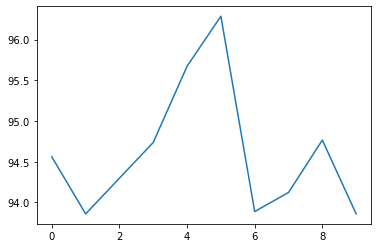

In [533]:
print(accuracy_epochs)
plt.plot(accuracy_epochs)
#[94.56140350877192, 93.85964912280699, 94.2982456140351, 94.73684210526315, 95.67251461988305, 96.28654970760235, 93.88888888888889, 94.12280701754385, 94.76608187134502, 93.85964912280701]

In [539]:
model.eval()

y_true8 = []
y_pred8 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true8.append(targets[l])
            y_pred8.append(targets[p])
print(classification_report(y_true8, y_pred8, target_names=targets))

              precision    recall  f1-score   support

     N95mask       0.97      0.89      0.93        80
   clothmask       0.92      0.98      0.95        91
      nomask       0.99      0.92      0.96        92
surgicalmask       0.87      0.95      0.91        79

    accuracy                           0.94       342
   macro avg       0.94      0.93      0.93       342
weighted avg       0.94      0.94      0.94       342



#### Old dataset 

In [540]:
running_loss_epochs2 = []
epochs_loss2 = []
accuracy_epochs2 = []
num_epochs = 10   # define no. of epochs to run
counter = 0
kf = KFold(n_splits=10, shuffle = True)
for i, (train_index, test_index) in enumerate(kf.split(train_val_loader2)):
    print("----------------K fold:{}----------:".format(i+1))
    #print("TRAIN:", train_index, "TEST:", test_index)

    train2 = torch.utils.data.Subset(train_val_loader2, train_index)
    test2 = torch.utils.data.Subset(train_val_loader2, test_index)

    trainloader2 = torch.utils.data.DataLoader(dataset=train2, shuffle=True, batch_size=50, num_workers=2)
    testloader2 = torch.utils.data.DataLoader(dataset=test2,shuffle=True, batch_size=50, num_workers=2)
    
    running_loss,epoch_loss,accuracy = train_model(model, criterion, optimizer, trainloader2, testloader2,num_epochs)
    running_loss_epochs2.append(np.mean(running_loss))
    epochs_loss2.append(np.mean(epoch_loss))
    accuracy_epochs2.append(np.mean(accuracy))

----------------K fold:1----------:


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 59.195402298850574
Loss of the current epoch:  4.9398708790540695
Accuracy of the Model in epoch 2 : 59.195402298850574
Loss of the current epoch:  4.9168160036206245
Accuracy of the Model in epoch 3 : 62.06896551724138
Loss of the current epoch:  4.902634570995967
Accuracy of the Model in epoch 4 : 60.3448275862069
Loss of the current epoch:  4.906584510579705
Accuracy of the Model in epoch 5 : 62.06896551724138
Loss of the current epoch:  4.8983071714639665
Accuracy of the Model in epoch 6 : 59.77011494252874
Loss of the current epoch:  4.909193854779005
Accuracy of the Model in epoch 7 : 61.49425287356321
Loss of the current epoch:  4.914093166589737
Accuracy of the Model in epoch 8 : 62.643678160919535
Loss of the current epoch:  4.939376940019429
Accuracy of the Model in epoch 9 : 60.3448275862069
Loss of the current epoch:  4.9458859985073405
Accuracy of the Model in epoch 10 : 60.3448275862069
Loss of the current epoch:  4.9669960051774975
----

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 59.195402298850574
Loss of the current epoch:  4.820606172084808
Accuracy of the Model in epoch 2 : 58.620689655172406
Loss of the current epoch:  4.855312671512365
Accuracy of the Model in epoch 3 : 58.04597701149425
Loss of the current epoch:  4.896488331258297
Accuracy of the Model in epoch 4 : 59.77011494252874
Loss of the current epoch:  4.905632587149739
Accuracy of the Model in epoch 5 : 59.195402298850574
Loss of the current epoch:  4.884767219424248
Accuracy of the Model in epoch 6 : 57.47126436781609
Loss of the current epoch:  4.884224014977614
Accuracy of the Model in epoch 7 : 57.47126436781609
Loss of the current epoch:  4.8982324334127565
Accuracy of the Model in epoch 8 : 58.620689655172406
Loss of the current epoch:  4.895386538468301
Accuracy of the Model in epoch 9 : 57.47126436781609
Loss of the current epoch:  4.898139494160811
Accuracy of the Model in epoch 10 : 56.896551724137936
Loss of the current epoch:  4.8911143384873865
--

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 53.44827586206896
Loss of the current epoch:  4.998336054384708
Accuracy of the Model in epoch 2 : 54.59770114942529
Loss of the current epoch:  4.905446168035269
Accuracy of the Model in epoch 3 : 55.172413793103445
Loss of the current epoch:  4.87049700319767
Accuracy of the Model in epoch 4 : 55.172413793103445
Loss of the current epoch:  4.860170600935817
Accuracy of the Model in epoch 5 : 54.02298850574713
Loss of the current epoch:  4.8524941697716715
Accuracy of the Model in epoch 6 : 55.172413793103445
Loss of the current epoch:  4.828670516610146
Accuracy of the Model in epoch 7 : 55.172413793103445
Loss of the current epoch:  4.846368149987289
Accuracy of the Model in epoch 8 : 55.172413793103445
Loss of the current epoch:  4.847393446601927
Accuracy of the Model in epoch 9 : 54.59770114942529
Loss of the current epoch:  4.860402317510711
Accuracy of the Model in epoch 10 : 54.59770114942529
Loss of the current epoch:  4.858356894552708
----

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 58.04597701149425
Loss of the current epoch:  4.7437824085354805
Accuracy of the Model in epoch 2 : 56.32183908045977
Loss of the current epoch:  4.801488734781742
Accuracy of the Model in epoch 3 : 56.32183908045977
Loss of the current epoch:  4.844979532063007
Accuracy of the Model in epoch 4 : 58.04597701149425
Loss of the current epoch:  4.814474796876311
Accuracy of the Model in epoch 5 : 58.04597701149425
Loss of the current epoch:  4.841778656840324
Accuracy of the Model in epoch 6 : 58.620689655172406
Loss of the current epoch:  4.855528771877289
Accuracy of the Model in epoch 7 : 55.74712643678161
Loss of the current epoch:  4.885265451456819
Accuracy of the Model in epoch 8 : 56.896551724137936
Loss of the current epoch:  4.8827018439769745
Accuracy of the Model in epoch 9 : 58.620689655172406
Loss of the current epoch:  4.870298119882743
Accuracy of the Model in epoch 10 : 58.04597701149425
Loss of the current epoch:  4.879994405061007
----

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 59.77011494252874
Loss of the current epoch:  4.8369733691215515
Accuracy of the Model in epoch 2 : 59.77011494252874
Loss of the current epoch:  4.896904680877924
Accuracy of the Model in epoch 3 : 60.3448275862069
Loss of the current epoch:  4.902958072721958
Accuracy of the Model in epoch 4 : 61.49425287356321
Loss of the current epoch:  4.910096103325486
Accuracy of the Model in epoch 5 : 59.195402298850574
Loss of the current epoch:  4.90375175923109
Accuracy of the Model in epoch 6 : 59.77011494252874
Loss of the current epoch:  4.919524146864812
Accuracy of the Model in epoch 7 : 58.620689655172406
Loss of the current epoch:  4.92154100643737
Accuracy of the Model in epoch 8 : 60.91954022988506
Loss of the current epoch:  4.927091370336711
Accuracy of the Model in epoch 9 : 59.195402298850574
Loss of the current epoch:  4.92578882806831
Accuracy of the Model in epoch 10 : 59.77011494252874
Loss of the current epoch:  4.933228983730078
---------

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 56.32183908045977
Loss of the current epoch:  4.834886373952031
Accuracy of the Model in epoch 2 : 57.47126436781609
Loss of the current epoch:  4.819501436315477
Accuracy of the Model in epoch 3 : 58.04597701149425
Loss of the current epoch:  4.872802197312315
Accuracy of the Model in epoch 4 : 58.620689655172406
Loss of the current epoch:  4.837312263902277
Accuracy of the Model in epoch 5 : 56.32183908045977
Loss of the current epoch:  4.8752491440623995
Accuracy of the Model in epoch 6 : 58.04597701149425
Loss of the current epoch:  4.880464708742996
Accuracy of the Model in epoch 7 : 57.47126436781609
Loss of the current epoch:  4.875291350430676
Accuracy of the Model in epoch 8 : 58.04597701149425
Loss of the current epoch:  4.874361330410466
Accuracy of the Model in epoch 9 : 59.195402298850574
Loss of the current epoch:  4.860376400045222
Accuracy of the Model in epoch 10 : 59.77011494252874
Loss of the current epoch:  4.848505223169923
------

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 52.87356321839081
Loss of the current epoch:  4.892358146607876
Accuracy of the Model in epoch 2 : 51.14942528735632
Loss of the current epoch:  4.797184547409415
Accuracy of the Model in epoch 3 : 54.02298850574713
Loss of the current epoch:  4.772991583993037
Accuracy of the Model in epoch 4 : 52.87356321839081
Loss of the current epoch:  4.747179781086743
Accuracy of the Model in epoch 5 : 54.02298850574713
Loss of the current epoch:  4.723315069824457
Accuracy of the Model in epoch 6 : 51.724137931034484
Loss of the current epoch:  4.727551586305101
Accuracy of the Model in epoch 7 : 54.59770114942529
Loss of the current epoch:  4.744490409003837
Accuracy of the Model in epoch 8 : 52.29885057471264
Loss of the current epoch:  4.743982306215912
Accuracy of the Model in epoch 9 : 52.29885057471264
Loss of the current epoch:  4.736367718627055
Accuracy of the Model in epoch 10 : 53.44827586206896
Loss of the current epoch:  4.756768010184169
--------

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 64.16184971098265
Loss of the current epoch:  4.888656355440617
Accuracy of the Model in epoch 2 : 64.73988439306359
Loss of the current epoch:  4.867306496948004
Accuracy of the Model in epoch 3 : 65.3179190751445
Loss of the current epoch:  4.816786368687947
Accuracy of the Model in epoch 4 : 63.58381502890174
Loss of the current epoch:  4.876505870372057
Accuracy of the Model in epoch 5 : 63.58381502890174
Loss of the current epoch:  4.879872407019138
Accuracy of the Model in epoch 6 : 64.16184971098265
Loss of the current epoch:  4.895561393350363
Accuracy of the Model in epoch 7 : 65.3179190751445
Loss of the current epoch:  4.881711473422391
Accuracy of the Model in epoch 8 : 65.3179190751445
Loss of the current epoch:  4.884059552103281
Accuracy of the Model in epoch 9 : 64.16184971098265
Loss of the current epoch:  4.891751625057724
Accuracy of the Model in epoch 10 : 64.73988439306359
Loss of the current epoch:  4.882566290721297
------------

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 54.33526011560693
Loss of the current epoch:  4.9573841243982315
Accuracy of the Model in epoch 2 : 53.179190751445084
Loss of the current epoch:  4.907916150987148
Accuracy of the Model in epoch 3 : 54.33526011560693
Loss of the current epoch:  4.929669285813968
Accuracy of the Model in epoch 4 : 56.64739884393064
Loss of the current epoch:  4.90249596349895
Accuracy of the Model in epoch 5 : 55.49132947976878
Loss of the current epoch:  4.906368893384934
Accuracy of the Model in epoch 6 : 54.91329479768786
Loss of the current epoch:  4.912112804750602
Accuracy of the Model in epoch 7 : 54.91329479768786
Loss of the current epoch:  4.891631944371121
Accuracy of the Model in epoch 8 : 54.91329479768786
Loss of the current epoch:  4.8763801525346935
Accuracy of the Model in epoch 9 : 55.49132947976878
Loss of the current epoch:  4.864079215874274
Accuracy of the Model in epoch 10 : 54.33526011560693
Loss of the current epoch:  4.849509999528527
-------

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy of the Model in epoch 1 : 58.38150289017341
Loss of the current epoch:  4.884003438055515
Accuracy of the Model in epoch 2 : 58.95953757225434
Loss of the current epoch:  4.937010619789362
Accuracy of the Model in epoch 3 : 56.06936416184971
Loss of the current epoch:  4.894042643407981
Accuracy of the Model in epoch 4 : 57.22543352601156
Loss of the current epoch:  4.888480186462402
Accuracy of the Model in epoch 5 : 58.38150289017341
Loss of the current epoch:  4.857555352151394
Accuracy of the Model in epoch 6 : 59.53757225433526
Loss of the current epoch:  4.8809598833322525
Accuracy of the Model in epoch 7 : 59.53757225433526
Loss of the current epoch:  4.880232658769403
Accuracy of the Model in epoch 8 : 57.80346820809249
Loss of the current epoch:  4.874968499876559
Accuracy of the Model in epoch 9 : 57.22543352601156
Loss of the current epoch:  4.867069454656707
Accuracy of the Model in epoch 10 : 60.115606936416185
Loss of the current epoch:  4.874839168787003


[60.747126436781606, 58.27586206896551, 54.712643678160916, 57.47126436781609, 59.885057471264375, 57.93103448275862, 52.93103448275862, 64.5086705202312, 54.85549132947976, 58.323699421965316]


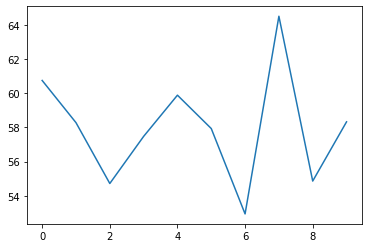

In [541]:
print(accuracy_epochs2)
plt.plot(accuracy_epochs2)

In [542]:
model.eval()

y_true9 = []
y_pred9 = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader2:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for l,p in zip(labels.numpy(), predicted.numpy()):
            y_true9.append(targets[l])
            y_pred9.append(targets[p])
print(classification_report(y_true9, y_pred9, target_names=targets))

              precision    recall  f1-score   support

     N95mask       0.23      0.21      0.22        42
   clothmask       0.20      0.21      0.20        43
      nomask       0.94      0.96      0.95        47
surgicalmask       0.95      0.93      0.94        41

    accuracy                           0.58       173
   macro avg       0.58      0.58      0.58       173
weighted avg       0.58      0.58      0.58       173



# Below is not in the project instrustion

#### Visualize the result

In [556]:
#Method for show the image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [557]:
model.to('cpu')
model.eval()
images, targets = next(iter(testloader))

In [558]:
with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)

<AxesSubplot:>

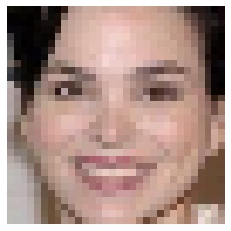

In [559]:
# This block is choosing randomly from the test set and out put the image
#You can run this block multiple times to try different images

rand_img = np.random.randint(50, size=1)[0]
probability = ps[rand_img].data.numpy().squeeze()
imshow(images[rand_img])

In [ ]:
#This block is for showing the prediction of the above image by showing the probability
#You should run it after you choose a image from the block above 
#You should run the whole "Visualize the result" block if you try to run the block below and come back to this one

ind = np.arange(4)
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Face Mask')

plt.yticks(np.arange(4))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();

#### User Input

<AxesSubplot:>

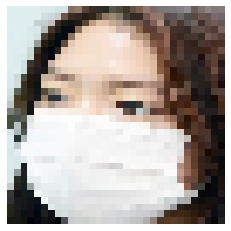

In [566]:
#User can input their own image by putting the image in folder "../Comp_472 Group Project/dataset/userInput/userInput"
#The folder contains an example
#REMEMBER only one image at a time can be process,for multiple images,only the first one in the folder will be considered

user_dir = "../Comp_472 Group Project - Copy/dataset/UserInput"
user_dataset = torchvision.datasets.ImageFolder(user_dir, transform = train_transform)
userloader = torch.utils.data.DataLoader(user_dataset, batch_size=64, shuffle = False)

model.to('cpu')
model.eval()
images, targets = next(iter(userloader))

with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)

probability = ps[0].data.numpy().squeeze()
imshow(images[0])


In [ ]:
#This block is for showing the prediction of the above image by showing the probability
#You should run it after you choose a image from the block above 

ind = np.arange(4)
targets = ['N95mask', 'clothmask', 'nomask', 'surgicalmask']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Face Mask')

plt.yticks(np.arange(4))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();